In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
import warnings
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import ttest_ind
import pickle
import os
import numpy as np
from sklearn import metrics
warnings.filterwarnings('ignore')

# Procesamiento de los datos

In [104]:
#Leer los dataframes
Meteo=pd.read_csv("UH_2023/DATOS_METEO.TXT", sep="|")
Eto=pd.read_csv("UH_2023/DATOS_ETO.TXT", sep="|")
df=pd.read_csv("UH_2023/UH_2023_TRAIN.txt", sep="|")

In [105]:
#Cambiar el formato de la fecha y extraer el año
Meteo["validTimeUtc"]=pd.to_datetime(Meteo["validTimeUtc"])
Meteo["Year"]=Meteo["validTimeUtc"].dt.strftime('%Y')
Meteo["Month"]=Meteo["validTimeUtc"].dt.strftime('%m')
Eto["date"]=pd.to_datetime(Eto["date"], format='%Y%m%d')
Eto["Year"]=Eto["date"].dt.strftime('%Y')
Eto["Month"]=Eto["date"].dt.strftime('%m')
df["Year"]=2000+df["CAMPAÑA"]
#Eliminamos las fechas porque no nos interesan
df.drop("CAMPAÑA", axis=1, inplace=True)
Eto.drop("date", axis=1, inplace=True)
Meteo.drop("validTimeUtc", axis=1, inplace=True)
#Cambiamos el formato de la altitud
df["ALTITUD"]=df["ALTITUD"].str.slice(0, 3)
#Anotamos cada mes para luego obtener los datos del año anterior al punto de predicción
etapas_cultivo=['01','02','03','04','05','06']
meses_año_anterior=['12','11','10','09','08','07']

Con esta función pretendemos extraer y agrupar los datos que serán de interés para la predicción, para realizar el entrenamiento, nos quedaremos con **la información de las parcelas y los datos meteorológicos, agrupados por año (desde junio del año a predecir hasta julio del año anterior, ajustándonos así a los datos que tenemos de la campaña de 2022 y ajustandonos también al ciclo anual de producción de la uva**. Se usan también los valores de producción y superficie para la finca y variedad en los ultimos 2 años para tener una concepción en el caso de haber métricas de la progesión de las fincas año a año.

In [75]:
def Agrupate_By_Year(last_year=2021, df=df, Eto=Eto, Meteo=Meteo):
    df_merged=df[df["Year"]==(last_year)].set_index(["ID_FINCA","VARIEDAD"])[['ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'MODO',
       'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION', "Year"]]
    print("df_merged", df_merged.shape)
    for n in range(1,3):
        df_year=df[df["Year"]==(last_year-n)].groupby(["ID_FINCA", "VARIEDAD"]).sum()[['PRODUCCION', 'SUPERFICIE']]
        #Calculamos la rentabilidad de las parcelas de cada estación meteorológica en los años enteriores
        year="-"+str(n)
        df_merged=df_merged.merge(df_year, suffixes=('',year), on=["ID_FINCA", "VARIEDAD"], how="left")
        print("df_merged años prod", df_merged.shape)
    #Generamos agregados anuales de las diferentes condiciones climatológicas
    df_eto=Eto[Eto["Year"]==(str(last_year))].groupby(["ID_ESTACION"]).aggregate(['mean'])
    #También generaremos los agregados para cada etapa del cultivo de la vid
    for items in etapas_cultivo:
        prueba=Eto[(Eto["Year"]==(str(last_year))) & (Eto["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['mean'])
        df_eto=df_eto.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    for items in meses_año_anterior:
        prueba=Eto[(Eto["Year"]==(str(last_year-1))) & (Eto["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['mean'])
        df_eto=df_eto.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    df_merged=df_merged.reset_index().merge(df_eto, on="ID_ESTACION")
    print("df_merged eto", df_merged.shape)
    #Generamos agregados anuales de las diferentes condiciones climatológicas
    df_meteo=Meteo[Meteo["Year"]==(str(last_year))].groupby(["ID_ESTACION"]).aggregate(['mean'])
    #También generaremos los agregados para cada etapa del cultivo de la vid
    for items in etapas_cultivo:
        prueba=Meteo[(Meteo["Year"]==(str(last_year))) & (Meteo["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['mean'])
        df_meteo=df_meteo.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    for items in meses_año_anterior:
        prueba=Meteo[(Meteo["Year"]==(str(last_year-1))) & (Meteo["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['mean'])
        df_meteo=df_meteo.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    df_merged=df_merged.merge(df_meteo, on="ID_ESTACION")
    print("df_merged meteo", df_merged.shape)
    return(df_merged)

# Modelo para rellenar los valores de Superficie

Dado la cruzial importancia de la superficie a la hora de predecir la producción y al no estar anotados los datos de superficie para los años anteriores a 2020, realizaremos un modelo de **RandomForest** para la predicción de los valores restantes de superficie y poder así usarlos en el modelo de predicción de la producción.

In [76]:
#Fincas en las que sí que se ha anotado los metros de superficie
df_sup=df[(df["SUPERFICIE"]!=0) & (df["PRODUCCION"].notna())]

In [77]:
df_sup
superficie=df_sup.pop("SUPERFICIE")
X_train, X_test, y_train, y_test = train_test_split(df_sup, superficie, test_size=0.33, random_state=1)
variables=X_train.columns
cat_variables=['ID_FINCA','VARIEDAD','ID_ZONA','ID_ESTACION','MODO','TIPO','COLOR', "ALTITUD"]
variables=variables.drop(cat_variables).to_list()

In [78]:
#Pipeline para el procesamiento de variables categóricas
categoricas= Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value="None")), 
                     ('onehot', OneHotEncoder(handle_unknown='ignore'))])
#Pipeline para el procesamiento de variables numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('scaler', StandardScaler())])

hack_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, variables),
        ('cat', categoricas, cat_variables)])

In [79]:
hack_pipe_RF = Pipeline([('prep', hack_trans),
                         ('clas', RandomForestRegressor())])

In [80]:
#Entrenamiento del modelo
parameters={'clas__bootstrap': [True], 'clas__max_depth': [100], 'clas__max_features': ['auto'], 
            'clas__min_samples_leaf': [1],'clas__min_samples_split': [2], 'clas__n_estimators': [600]}

hack_pipe_RF = Pipeline([('prep', hack_trans),
                         ('clas', RandomForestRegressor())])

GS = GridSearchCV(hack_pipe_RF, param_grid=parameters, cv=5, verbose=10, scoring='neg_root_mean_squared_error')
GS.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600
[CV 1/5; 1/1] END clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600; total time=   8.8s
[CV 2/5; 1/1] START clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600
[CV 2/5; 1/1] END clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600; total time=   8.6s
[CV 3/5; 1/1] START clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600
[CV 3/5; 1/1] END clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['PRODUCCION',
                                                                          'Year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                        

In [81]:
print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

Mejor score:  -1.535250533898104
Mejor configuración de parámetros:  {'clas__bootstrap': True, 'clas__max_depth': 100, 'clas__max_features': 'auto', 'clas__min_samples_leaf': 1, 'clas__min_samples_split': 2, 'clas__n_estimators': 600}


In [82]:
RF_superficie = GS.best_estimator_
y_pred=RF_superficie.predict(X_test)

In [83]:
print("El modelo tiene un valor de r2 para la predicción de la superficie de: ", r2_score(y_test, y_pred))

El modelo tiene un valor de r2 para la predicción de la superficie de:  0.7493096969196595


Con este modelo de RandomForest parece que tenemos la capacidad de inferir (aunque sea en parte) un tamaño aproximado de las parcelas en las que no había sido anotada su superficie, puediendo usar esa variable en el entrenamiento del modelo de predicción de la producción.

In [84]:
RF_superficie.fit(df_sup, superficie)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PRODUCCION', 'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEn

In [85]:
#Predecimos los valores de superficie
df_sup_0=df[(df["SUPERFICIE"]==0) & (df["PRODUCCION"].notna())]

In [86]:
#Realizamos la predicción
df_sup_0["SUPERFICIE"]=RF_superficie.predict(df_sup_0.drop("SUPERFICIE", axis=1))

In [87]:
#Juntamos ambos dataframes
df=pd.concat([df[(df["SUPERFICIE"]!=0)], df_sup_0])
df

ID_FINCA  ID_ZONA  ID_ESTACION ALTITUD  VARIEDAD  MODO  TIPO  COLOR  \
6476     48626      302           13     600        32     2     0      1   
6477     47921      302           13     600        32     2     0      1   
6478      5696      919           14     650        59     1     0      1   
6480     98814      919           14     650        32     2     0      1   
6481     98814      919           14     650        40     2     0      1   
...        ...      ...          ...     ...       ...   ...   ...    ...   
7530     13054      464           14     650        59     2     0      1   
7535     16692      464           14     650        59     2     0      1   
7536     78846      464           14     650        59     2     0      1   
7537     59317      464           14     650        59     2     0      1   
7563     13439      428           14     730        32     2     0      1   

      SUPERFICIE  PRODUCCION  Year  
6476    3.750300   19511.107  2020  
6477    7.373500   38678.893  2020  
6478    7.620000    7092.800  2020  
6480    7.165700    6660.000  2020  
6481    3.500000    6970.000  2020  
...          ...         ...   ...  
7530    2.314676    6432.335  2021  
7535    0.879783    2007.876  2021  
7536    0.920856    2460.471  2021  
7537    0.879783    2005.133  2021  
7563    0.766519    2509.455  2021  

[9592 rows x 11 columns]

In [88]:
#Guardar el modelo y los resultados
filename = 'Models/RF_superficie.sav'
pickle.dump(RF_superficie, open(filename, 'wb'))

# **Desarrollo del modelo de machine learning** 

Dado al reducido número de muestras y la importancia de la explicabilidad en el modelo, utilizaremos
modelos de machine learning clásicos, basados en **Random Forest** en lugar de modelos complejos de
redes neuronales los cuales padecen del efecto caja negra que impiden hacer uso del modelo más allá
de la predicción de los valores.

## Pre-processing pipeline
Generaremos un pipeline de preprocesamiento, codificando como variables categóricas mediante un _"OneHotEncoder"_ las variables 'ID_FINCA', 'VARIEDAD', 'ID_ZONA', 'ID_ESTACION', 'MODO', 'TIPO', 'ALTITUD' y 'COLOR'. Las demás variables serán estandarizadas mediante un _"StandardScaler"_ para evitar así que algunas variables tengan mayor peso en el entrenamiento que otras.

In [89]:
# DataFrame con los resultados
# Si no se han generado ningún resultado lo genera.
if not os.path.isfile("results.csv"):
    results = pd.DataFrame(columns=['Modelo','$R^2$ Entrenamiento','$R^2$ Test', 
                                         'MAE Entrenamiento', 'MAE Test']).set_index('Modelo')
# Si se habían generado anteriormente, y el archivo está disponible, lo lee. 
else:
    results=pd.read_csv("results.csv", index_col=0)

#Función para el análisis del desempeño de los modelos
def show_results(description, model, X_train, y_train, X_test, y_test, is_log=False):
    train_r2 = model.score(X_train,y_train)
    print('Score done')
    test_r2 = model.score(X_test, y_test)
    print('Score 2 done')
    # Calcula el error    
    train_mae = mean_absolute_error(y_train, model.predict(X_train))
    test_mae = mean_absolute_error(y_test, model.predict(X_test))
    # Muetra los resultados en formato legible
    print('Training \t\t Test')
    print('-------- \t\t ----')
    print(f"R\u00B2 = {train_r2:.3f}\t\tR\u00B2 = {test_r2:.3f}")
    print(f"MAE = {train_mae:.2f}\t\t\t\t\tMAE = {test_mae:.2f}")
    results.loc[description]= (train_r2, test_r2, train_mae, test_mae)

Utilizaremos para el entrenamiento, los datos agregados desde 2016 a 2020, usando los datos de 2021 como conjunto de validación, de esta manera tendremos una aproximación que sea lo más similar posible al uso productivo que se le dará a la herramienta, utilizando los valores de años anteriores para la predicción de la campaña actual de produccion. Los datos de 2014 y 2015 fueron descartados al no tener información precisa de algunos de los meses.

In [90]:
#Utilizamos la función generada para crear el dataframe que usaremos en entrenamiento, centrado en el año 2021
X_2020=Agrupate_By_Year(last_year=2020, df=df, Eto=Eto, Meteo=Meteo)
X_2019=Agrupate_By_Year(last_year=2019, df=df, Eto=Eto, Meteo=Meteo)
X_2018=Agrupate_By_Year(last_year=2018, df=df, Eto=Eto, Meteo=Meteo)
X_2017=Agrupate_By_Year(last_year=2017, df=df, Eto=Eto, Meteo=Meteo)
X_2016=Agrupate_By_Year(last_year=2016, df=df, Eto=Eto, Meteo=Meteo)
X_train=pd.concat([X_2020,X_2019,X_2018,X_2017,X_2016])
X_test=Agrupate_By_Year(last_year=2021, df=df, Eto=Eto, Meteo=Meteo)
#Eliminamos los casos en los que la producción excede el percentil 99 ya que son outlyiers
X_train=X_train[X_train["PRODUCCION"]<X_train["PRODUCCION"].quantile(q=0.99)]
#Separamos los datos de entrenamiento y test que serán usados para evaluar nuestro modelo
y_train=X_train.pop("PRODUCCION")
y_test=X_test.pop("PRODUCCION")
variables=X_train.columns
cat_variables=['ID_FINCA','VARIEDAD','ID_ZONA','ID_ESTACION','MODO','TIPO','COLOR', "ALTITUD"]
variables=variables.drop(cat_variables).to_list()
print(f' dataset train has {X_train.shape}')
print(f' dataset test has {X_test.shape}')

df_merged (1006, 9)
df_merged años prod (1006, 11)
df_merged años prod (1006, 13)
df_merged eto (1006, 3564)
df_merged meteo (1006, 3967)
df_merged (1055, 9)
df_merged años prod (1055, 11)
df_merged años prod (1055, 13)
df_merged eto (1055, 3564)
df_merged meteo (1055, 3967)
df_merged (1061, 9)
df_merged años prod (1061, 11)
df_merged años prod (1061, 13)
df_merged eto (1061, 3564)
df_merged meteo (1061, 3967)
df_merged (1017, 9)
df_merged años prod (1017, 11)
df_merged años prod (1017, 13)
df_merged eto (1017, 3564)
df_merged meteo (1017, 3967)
df_merged (1079, 9)
df_merged años prod (1079, 11)
df_merged años prod (1079, 13)
df_merged eto (1079, 3564)
df_merged meteo (1079, 3967)
df_merged (1044, 9)
df_merged años prod (1044, 11)
df_merged años prod (1044, 13)
df_merged eto (1044, 3564)
df_merged meteo (1044, 3967)
 dataset train has (5165, 3966)
 dataset test has (1044, 3966)


In [91]:
#Pipeline para el procesamiento de variables categóricas
categoricas= Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=None)), 
                     ('onehot', OneHotEncoder(handle_unknown='ignore'))])
#Pipeline para el procesamiento de variables numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('scaler', StandardScaler())])

hack_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, variables),
        ('cat', categoricas, cat_variables)])

In [92]:
RF = RandomForestRegressor(bootstrap=True, max_depth=20, max_features='auto',
                            min_samples_leaf=4, min_samples_split=5, n_estimators=200)
hack_pipe_RF = Pipeline([('prep', hack_trans),
                         ('clas', RF)], verbose=10)
hack_pipe_RF.fit(X_train, y_train)

description = 'Random forest para la predicción producción vinícola con modelo para superficie'

[Pipeline] .............. (step 1 of 2) Processing prep, total=   1.2s
[Pipeline] .............. (step 2 of 2) Processing clas, total= 6.4min


In [93]:
show_results(description, hack_pipe_RF, X_train, y_train, X_test, y_test)

Score done
Score 2 done
Training 		 Test
-------- 		 ----
R² = 0.947		R² = 0.726
MAE = 1203.22					MAE = 3700.96


In [94]:
#Guardar el modelo y los resultados
filename = 'Models/RF_produccion.sav'
pickle.dump(hack_pipe_RF, open(filename, 'wb'))
results.to_csv("results.csv")

In [95]:
#Estudiar como el modelo funciona a la hora de agregar por parcela
X_test["PRODUCCION"]=y_test
X_test["PRODUCCION_pred"]=hack_pipe_RF.predict(X_test.drop("PRODUCCION",axis=1))
X_test_finca=X_test.groupby("ID_FINCA").sum()[["PRODUCCION","PRODUCCION_pred"]]
print("El modelo tiene un valor de r2 para la predicción de la producción de: ", 
      r2_score(X_test_finca["PRODUCCION"], X_test_finca["PRODUCCION_pred"]))
print("El modelo tiene un valor de MAE para la predicción de la producción de: ", 
      mean_absolute_error(X_test_finca["PRODUCCION"], X_test_finca["PRODUCCION_pred"]))

El modelo tiene un valor de r2 para la predicción de la producción de:  0.8289393140423958
El modelo tiene un valor de MAE para la predicción de la producción de:  4359.398658761767


    Podemos observar que el desempeño del modelo es mayor cuando llega la hora de agrupar por fincas y calcular la producción total de cada una de las fincas, teniendo en este caso un valor de r2 de 0.82 y MAE de 4376.72

In [96]:
RF = pickle.load(open("Models/RF_produccion.sav", 'rb'))
#Entrenamos el modelo haciendo uso de todos los datos
X_train_2=pd.concat([X_2020,X_2019,X_2018,X_2017,X_2016, X_test.drop("PRODUCCION_pred",axis=1)])
#Eliminamos los casos en los que la producción excede el percentil 99 ya que son outlyiers que pueden complicar el entrenamiento del modelo
X_train_2=X_train_2[X_train_2["PRODUCCION"]<X_train_2["PRODUCCION"].quantile(q=0.99)]
#Separamos los datos de entrenamiento y test que serán usados para evaluar nuestro modelo
y_train_2=X_train_2.pop("PRODUCCION")

In [97]:
hack_pipe_RF.fit(X_train_2, y_train_2)

[Pipeline] .............. (step 1 of 2) Processing prep, total=   1.5s
[Pipeline] .............. (step 2 of 2) Processing clas, total= 8.8min


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SUPERFICIE', 'Year',
                                                   'PRODUCCION-1',
                                                   'SUPERFICIE-1',
                                                   'PRODUCCION-2',
                                                   'SUPERFICIE-2',
                                                   ('DewpointLocalAfternoonAvg',
                                                    'mean'),
                                                   ('DewpointLocalAfternoonMax',
  

In [98]:
#Guardar el modelo completo
filename = 'Models/RF_produccion_completo.sav'
pickle.dump(hack_pipe_RF, open(filename, 'wb'))

#### Predicción de los valores de 2022

In [106]:
X_2022=Agrupate_By_Year(last_year=2022, df=df, Eto=Eto, Meteo=Meteo)
X_2022.drop("PRODUCCION", axis=1, inplace=True)
X_2022["PRODUCCION"]=RF.predict(X_2022)
X_2022=X_2022[["ID_FINCA", "VARIEDAD","MODO", "TIPO", "COLOR", "SUPERFICIE", "PRODUCCION"]]

df_merged (1075, 9)
df_merged años prod (1075, 11)
df_merged años prod (1075, 13)
df_merged eto (1075, 3564)
df_merged meteo (1075, 3967)


In [107]:
X_2022

ID_FINCA  VARIEDAD  MODO  TIPO  COLOR  SUPERFICIE    PRODUCCION
0        48626        32     2     0      1      3.7503  25436.868270
1        47921        32     2     0      1      7.3735  41741.512199
2         5696        59     1     0      1      7.6200  22216.803193
3        98814        32     2     0      1      3.3267  20282.834176
4        98814        40     2     0      1      2.7724   9302.741571
...        ...       ...   ...   ...    ...         ...           ...
1070     37461        52     2     0      1      3.6800  26810.330458
1071     58769        32     2     0      1      4.2500  35065.554415
1072     58769        59     2     0      1      4.0700  34430.620229
1073     88928        40     2     0      1      4.5727  40462.756762
1074     88928        52     2     0      1      1.6099  10872.300382

[1075 rows x 7 columns]

In [6]:
df2 = X_2022.sort_values(["ID", "VARIEDAD", "MODO", "TIPO", "COLOR","SUPERFICIE"],
              ascending = [True, True, True, True, True, True])

ID  VARIEDAD  MODO  TIPO  COLOR  SUPERFICIE  PRODUCCION
241     439         9     2     0      0        1.08     3234.62
750     447        40     2     0      1        0.47     2362.49
589     523        32     2     0      1        0.65     1592.85
1055    702        59     2     0      1        1.13     5272.82
299     797        59     1     0      1        7.51    24873.95
...     ...       ...   ...   ...    ...         ...         ...
892   99282        59     2     0      1        1.62     8505.32
783   99377        52     2     0      1        0.65     3388.82
272   99693        81     1     0      1        6.34    27910.24
13    99793        52     2     0      1        0.13      514.91
12    99793        87     2     0      0        0.02      376.48

[1075 rows x 7 columns]

In [8]:
df2.to_csv("UH2023_Universidad de Castilla La Mancha (UCLM)_Pistachio_1.txt", sep="|", float_format='%.2f', header=False, index=False)

# Análisis de explicabilidad
Dada la importancia crucial en el proyecto de la explicabilidad de nuestro modelo y dado a la total trasparencia de los modelos de RandomForest, procedimos una vez entrenado el modelo a estudiar en qué basa este la toma de decisiones, para ello hicimos uso de gráficos __shap__ que permiten ver para cada valor de predicción, ver que variables han tenido mayor o menor relevancia en el valor predicho. Para ello nos centramos en los valores más extremos, aquellas 5 muestras con mayor y menor valor de producción predicho por el modelo en 2022.

In [109]:
import shap
shap.initjs()

Seleccionaremos las muestras con los valores mayores y menores para cada una de las variables de interés para hacer los análisis de la predicción.

In [110]:
#Modelo para la predicción de ERK
RF = pickle.load(open("Models/RF_produccion_completo.sav", 'rb'))
X_2022 = Agrupate_By_Year(last_year=2022, df=df, Eto=Eto, Meteo=Meteo)
y_pred = RF.predict(X_2022.drop("PRODUCCION",axis=1))
#Nos quedaremos con las filas para las que ha predicho un valor mayor y menor de produccion
max_idx=pd.DataFrame(y_pred)[0].nlargest(5).index.to_list()
min_idx=pd.DataFrame(y_pred)[0].nsmallest(5).index.to_list()
samples=X_2022.iloc[max_idx+min_idx]

df_merged (1075, 9)
df_merged años prod (1075, 11)
df_merged años prod (1075, 13)
df_merged eto (1075, 3564)
df_merged meteo (1075, 3967)


Una cosa que era de esperar es que la muestra con menor valor predicho es a tiempo 0, cosa que podría ser comprensible si los tratamientos llevan a un cierto aumento de los niveles de fosforilación de ERK.

In [111]:
explainer = shap.TreeExplainer(RF._final_estimator)
sampleID=samples.index

In [113]:
samples=RF.named_steps["prep"].transform(samples.drop(["PRODUCCION"],axis=1))

In [114]:
#Seleccionamos las variables con los nuevos nombres tras el preprocesamiento
new_cat_cols = RF.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"].get_feature_names(cat_variables)
all_cols = np.concatenate([variables, new_cat_cols])

In [118]:
def shap_plot(n, plot="Large"):
    #Estadísiticos shap de la importancia de las variables en la muestra seleccionada
    choosen_instance = samples[n]
    df_shap=pd.DataFrame(choosen_instance).T
    df_shap.columns=all_cols
    shap_values = explainer.shap_values(df_shap)
    #Mostramos las 10 variables con mayor importancia
    prueba_shap=pd.DataFrame(shap_values[0]).T
    prueba_shap.columns=all_cols
    #Seleccionamos si las 10 mayores o las 10 menores según que queramos mostrar
    if plot=="Large":
        print(prueba_shap.T[0].nlargest(10))
    else:
        print(prueba_shap.T[0].nsmallest(10))
    #Gráfico shap
    return shap.force_plot(explainer.expected_value[0], shap_values[0], df_shap)

### Muestras con los valores de predicción más elevados

In [120]:
shap_plot(0)

SUPERFICIE                               29971.673938
PRODUCCION-1                              8083.020649
PRODUCCION-2                              2057.514455
ID_ZONA_506                                612.899121
VARIEDAD_32                                224.086056
MODO_1                                     152.030671
(UVIndexLocalAfternoonAvg01, mean)         134.873021
MODO_2                                     125.657767
(PrecipAmountLocalNighttimeMax, mean)       86.678117
(GustLocalOvernightMin, mean)               54.626617
Name: 0, dtype: float64


In [121]:
shap_plot(1)

SUPERFICIE                               27185.388233
PRODUCCION-1                              8108.124600
PRODUCCION-2                              2403.178051
ID_ZONA_506                                852.463368
VARIEDAD_32                                314.464886
SUPERFICIE-1                               309.263588
(UVIndexLocalAfternoonAvg01, mean)         231.369481
MODO_1                                     175.822755
MODO_2                                     165.188227
(PrecipAmountLocalNighttimeMax, mean)      113.496723
Name: 0, dtype: float64


In [122]:
shap_plot(2)

SUPERFICIE                               29401.299260
PRODUCCION-1                              7497.912349
PRODUCCION-2                              2133.209504
(UVIndexLocalAfternoonAvg01, mean)         158.919225
MODO_1                                     140.882072
MODO_2                                     123.212762
(PrecipAmountLocalNighttimeMax, mean)       67.791788
(GustLocalOvernightMin, mean)               67.589604
VARIEDAD_87                                 65.161545
(WindSpeedLocalAfternoonMin08, mean)        51.325599
Name: 0, dtype: float64


In [123]:
shap_plot(3)

SUPERFICIE                               29103.401051
PRODUCCION-1                              8016.738135
PRODUCCION-2                              1965.528785
ID_ZONA_506                                718.230459
MODO_1                                     151.285423
(UVIndexLocalAfternoonAvg01, mean)         145.121724
MODO_2                                     130.703041
(PrecipAmountLocalNighttimeMax, mean)       93.300000
(GustLocalOvernightMin, mean)               57.239920
VARIEDAD_17                                 50.024672
Name: 0, dtype: float64


In [124]:
shap_plot(4)

SUPERFICIE                               26006.957604
PRODUCCION-1                              7945.901488
PRODUCCION-2                              2589.628195
ID_ZONA_506                                686.259780
SUPERFICIE-1                               268.284289
VARIEDAD_32                                227.138451
MODO_1                                     205.446914
MODO_2                                     191.895194
(UVIndexLocalAfternoonAvg01, mean)         177.621463
(PrecipAmountLocalNighttimeMax, mean)       95.275365
Name: 0, dtype: float64


    A partir del análsiis de explicabilidad podemos ver que en las fincas que mayor producción ha predicho el modelo, las variables con mayor importancia son la producción en los años anteriores y la superficie de las fincas. Este hecho era esperable, ya que las fincas que durante los años anteriores estuvieran generando valores muy elevados de producción es esperable que los años siguientes también tengan elevadas producciones de uva. Respecto a la superficie, durante el análsis de los datos ya habíamos predicho la crucial importancia de la superficie de las parcelas a la hora de calcular la producción.

    Una de las cosas sorprendentes es que entre las variables con mayor importancia, una de ellas es que la finca esté en la zona 506. Esto atrajo nuestra curiosidad ya que podría inferir que en esta zona existe una diferencia significativa en la producción de las parcelas, por ello quisimos adentrarnos en el estudio de esta diferencia.

In [125]:
df_506=pd.DataFrame(df[df["ID_ZONA"]==506]["PRODUCCION"])
df_506["506"]="506"
df_rest=pd.DataFrame(df[df["ID_ZONA"]!=506]["PRODUCCION"])
df_rest["506"]="Resto"
df_analisis=pd.concat([df_506,df_rest])

Diferencia de la producción de la zona 506 con respecto al resto
Ttest_indResult(statistic=16.00681529337969, pvalue=7.67552216857245e-57)


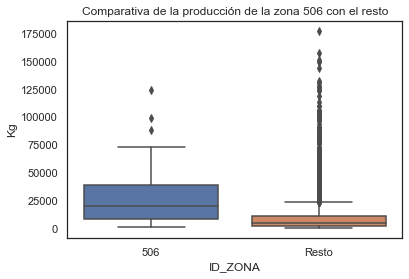

In [126]:
sns.boxplot(data=df_analisis, x="506", y="PRODUCCION")
plt.xlabel("ID_ZONA")
plt.ylabel("Kg")
data_506 = df_analisis[df_analisis["506"]=="506"].copy()
data_rest = df_analisis[df_analisis["506"]=="Resto"].copy()
print("Diferencia de la producción de la zona 506 con respecto al resto")
print(ttest_ind(data_506['PRODUCCION'].dropna(), data_rest['PRODUCCION'].dropna()))
plt.title("Comparativa de la producción de la zona 506 con el resto")
plt.show()

    El análisis concluyó que efectivamente las fincas en la zona 506 producen una significativamente mayor cantidad de uva, esto debería estudiarse para saber si se debe a sus condiciones climáticas, de suelo, microbiológicas o administrativas e implantar si fuera posible esos cambios en las otras fincas para mejorar la productividad.

### Muestras con los valores de predicción más reducidos

In [127]:
shap_plot(5, plot="")

SUPERFICIE                  -6520.953238
PRODUCCION-1                -1476.222482
PRODUCCION-2                 -486.349297
MODO_1                       -179.503326
MODO_2                       -157.413225
VARIEDAD_59                   -28.382640
ID_ESTACION_3                 -10.978828
(windGust01, mean)            -10.350127
(GustLocalDayMin06, mean)      -8.900297
(precipMtd09, mean)            -8.188972
Name: 0, dtype: float64


In [128]:
shap_plot(6, plot="")

SUPERFICIE                              -6722.338026
PRODUCCION-1                            -1437.271727
PRODUCCION-2                             -489.472198
MODO_1                                   -185.203806
MODO_2                                   -163.203497
VARIEDAD_17                               -37.239780
(precipMtd09, mean)                        -8.219918
(windGust01, mean)                         -7.113455
(PrecipAmountLocalEveningMin04, mean)      -6.184224
(GustLocalMorningMax12, mean)              -5.160108
Name: 0, dtype: float64


In [129]:
shap_plot(7, plot="")

SUPERFICIE                              -7268.495283
PRODUCCION-1                            -1392.431829
PRODUCCION-2                             -484.808022
VARIEDAD_9                                -16.381587
(GustLocalDayMin06, mean)                 -11.212166
ALTITUD_610                                -7.237520
(precipMtd09, mean)                        -5.702123
(PrecipAmountLocalEveningMin04, mean)      -5.560788
VARIEDAD_32                                -5.061712
VARIEDAD_15                                -4.990841
Name: 0, dtype: float64


In [130]:
shap_plot(8, plot="")

SUPERFICIE                                  -6716.276727
PRODUCCION-1                                -1465.842476
PRODUCCION-2                                 -486.127742
MODO_1                                       -177.969180
MODO_2                                       -157.162471
(precipMtd09, mean)                            -7.995712
(PrecipAmountLocalEveningMin04, mean)          -6.053999
VARIEDAD_32                                    -4.753110
(VisibilityLocalEveningMin01, mean)            -4.370636
(RelativeHumidityLocalDaytimeMin03, mean)      -4.210675
Name: 0, dtype: float64


In [131]:
shap_plot(9, plot="")

SUPERFICIE                                    -7527.365128
PRODUCCION-1                                  -1369.269340
PRODUCCION-2                                   -258.433768
(GustLocalDayMin06, mean)                       -11.424364
(precipMtd09, mean)                              -6.496274
(PrecipAmountLocalEveningMin04, mean)            -5.564153
VARIEDAD_15                                      -5.202368
(RelativeHumidityLocalDaytimeMin03, mean)        -4.783866
(RelativeHumidityLocalAfternoonMin04, mean)      -4.348271
(VisibilityLocalEveningMin01, mean)              -4.085232
Name: 0, dtype: float64


    Respecto a las muestras con menor valor de predicción en la producción, vemos nuevamente que los valores de superficie y producción en años anteriores son los que mayor peso tienen en la predicción de valores reducidos de producción.

    También parece interesante que algunas variedades de uva parecen tener cierta propensión a valores de predicción más reducidos, esto puede significar que la productividad de estas variedades es más reducida y eso podría afectar a la rentabilidad de algunas parcelas. Por ello se realizó un análisis un poco más profundo del efecto de las variedades de uva con respecto a la producción de las parcelas, prestando especial atención a las variedades 32 y 59 que son las que han aparecido con mayor frecuencia.

Text(0.5, 1.0, 'Produccion según la variedad')

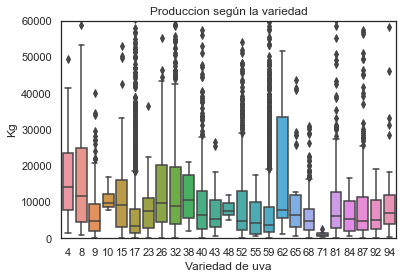

In [132]:
sns.boxplot(data=df, x="VARIEDAD", y="PRODUCCION")
plt.xlabel("Variedad de uva")
plt.ylabel("Kg")
plt.ylim(top=60000, bottom=0)
plt.title("Produccion según la variedad")

In [133]:
data_32 = df[df["VARIEDAD"]==32].copy()
rest_32 = df[df["VARIEDAD"]!=32].copy()
data_59 = df[df["VARIEDAD"]==59].copy()
rest_59 = df[df["VARIEDAD"]!=59].copy()
print("Diferencia de la producción de la variedad 32 con respecto al resto")
print(ttest_ind(data_32['PRODUCCION'].dropna(), rest_32['PRODUCCION'].dropna()))
print("Diferencia de la producción de la variedad 59 con respecto al resto")
print(ttest_ind(data_59['PRODUCCION'].dropna(), rest_59['PRODUCCION'].dropna()))

Diferencia de la producción de la variedad 32 con respecto al resto
Ttest_indResult(statistic=14.546247872889095, pvalue=2.2728763701903e-47)
Diferencia de la producción de la variedad 59 con respecto al resto
Ttest_indResult(statistic=-5.330873779745589, pvalue=1.00243210143956e-07)


    Se puede observar que pese a que la diferencia no fue apreciable en el análisis preliminar de las variables, las variedades 32 y 59 tienen una menor productividad y eso se podría tener en cuenta a la hora de desarrollar la estrategia empresarial.

# Conclusión

Mediante el desarrollo de un modelo de predicción de la producción basado en **RandomForest** se llegó a 3 conclusiones principales:

    -El modelo tiene la capacidad de explicar parte de la varianza de la producción de uva, con un desempeño admisible para su uso en la práctica con un MAE de 4376 y un valor de r2 de 0.82 para el conjunto de validación.
    -El análisis de la explicabilidad muestra que los valores de producción de años anteriores, así como los valores de superficie son los que mayor importancia tienen en la producción de las fincas, más allá de los posibles efectos de la meteorología.
    -Un análisis más profundo de los gráficos de explicabilidad han mostrado el efecto positivo que tienen determinadas zonas (en este caso la 506) en la producción de mejores cosechas, así como el efecto negativo de determinadas variedades de uva (32 y 59).